In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [24]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set. 
most_recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date[0]

'2017-08-23'

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in the data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago, Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame with explicit column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Display the sorted DataFrame
print(precipitation_df)



            Date  Precipitation
0     2016-08-24           0.08
1006  2016-08-24            NaN
1524  2016-08-24           2.15
702   2016-08-24           2.28
360   2016-08-24           2.15
...          ...            ...
1522  2017-08-22           0.00
1523  2017-08-23           0.08
359   2017-08-23           0.00
1005  2017-08-23           0.00
2222  2017-08-23           0.45

[2223 rows x 2 columns]


In [31]:
print(len(precipitation_df))

2223


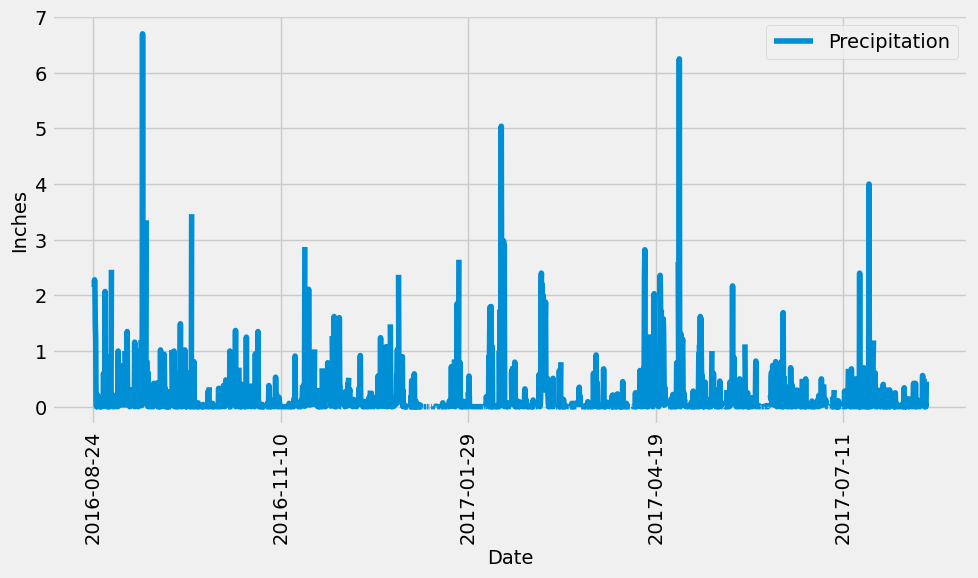

In [29]:
# Plot the data using Pandas plotting with Matplotlib
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10, 6), legend=True, rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.show()

In [35]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(len(precipitation_df))
#summary= (precipitation_df).describe()
#print(summary)

2223


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).count()

9

In [40]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

sel = [Measurement.station, func.count(Measurement.station)]
station_count = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_count


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

active_station = sel.first()
print(active_station)

In [42]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
if station_count:
    # Extract the most active station ID (assuming it's the first one in the result)
    most_active_station_id = station_count[0][0]

    # Calculate the lowest, highest, and average temperature for the most active station
    temperature_stats = (
        session.query(
            func.min(Measurement.tobs).label('min_temperature'),
            func.max(Measurement.tobs).label('max_temperature'),
            func.avg(Measurement.tobs).label('avg_temperature')
        )
        .filter(Measurement.station == most_active_station_id)
        .all()
    )

    # Display the result
    print(f"Temperature Statistics for Station {most_active_station_id}:")
    print(f"Lowest Temperature: {temperature_stats[0][0]}")
    print(f"Highest Temperature: {temperature_stats[0][1]}")
    print(f"Average Temperature: {temperature_stats[0][2]}")
else:
    print("No station data available.")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


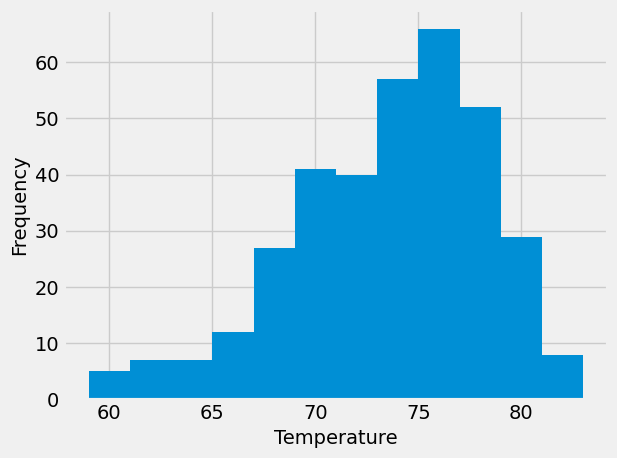

In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Assuming you have the most_active_station_id from the previous query

# Calculate the date one year from the last date in the data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = (
    session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id, Measurement.date >= one_year_ago, Measurement.date <= most_recent_date)).\
    all()


# Save the query results as a Pandas DataFrame with explicit column names
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Drop rows with null values (if necessary)
temperature_df = temperature_df.dropna()

# Plot the results as a histogram using Matplotlib
plt.figure#figsize=16,6)
plt.hist(temperature_df['Temperature'], bins=12) 
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [44]:
# Close Session
session.close()